In [200]:
import torch
from torch import nn, optim
from torch.nn import functional as F

import torch_geometric
from torch_geometric import datasets
from torch_geometric.data import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt

In [201]:
cora = datasets.Planetoid(root=".", name="Cora", transform=NormalizeFeatures())

In [202]:
dataset = cora[0]
print(f"Number sample: {len(cora.x)}")
print(f"Number of features: {cora.num_features}")
print(f"Number of classes: {cora.num_classes}")
print(f"Number of nodes: {dataset.num_nodes}")
print(f"Number of training nodes: {dataset.train_mask.sum()}")
print(f"Is undirected? {dataset.is_undirected()}")

Number sample: 2708
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of training nodes: 140
Is undirected? True


In [203]:
edges = dataset.edge_index.t()

In [204]:
labels = dataset.y

In [205]:
G = nx.Graph()
G.add_edges_from(edges.tolist())

In [206]:
color_map = {}
colors = ["blue", "green", "red", "yellow", "black", "orange", "magma"]
c_map = {i : colors[i] for i in range(7)}
nodes_color = []
nodes = []
for node in G:
  nodes.append(node)
  nodes_color.append(c_map[labels[node].item()])

In [207]:
carac = pd.DataFrame({"node" : nodes, "colors" : nodes_color})

carac['colors']=pd.Categorical(carac['colors'])
carac['colors'].cat.codes

0       6
1       6
2       6
3       6
4       0
       ..
2703    5
2704    0
2705    0
2706    0
2707    0
Length: 2708, dtype: int8

In [208]:
if not os.path.exists("./cora_graph.png"):
  plt.figure(figsize=(100, 50))
  pos = nx.kamada_kawai_layout(G)
  nx.draw(G, pos, node_color=carac['colors'].cat.codes, with_labels=True)
  plt.savefig("cora_graph.png", dpi=150, bbox_inches="tight")
  plt.show()
else:
  print("./cora_graph.png")

./cora_graph.png


In [209]:
TRAIN_RATIO = 0.8
TRAIN_LIMIT = int(TRAIN_RATIO * len(cora.x))
TEST_LIMIT = int((1 - TRAIN_RATIO) * len(cora.x))

In [210]:
class GNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size) -> None:
    super(GNN, self).__init__()
    self.conv1 = GCNConv(input_size, hidden_size)
    self.conv2 = GCNConv(hidden_size, hidden_size)
    self.conv3 = GCNConv(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    
  def forward(self, X, edges_index):
    out = X
    out = self.conv1(out, edges_index)
    out = out.relu()
    out = F.dropout(out, p=.5, training=self.training)
    
    out = self.conv2(out, edges_index)
    out = out.relu()
    out = F.dropout(out, p=.5, training=self.training)
    
    out = self.conv3(out, edges_index)
    out = out.relu()
    out = F.dropout(out, p=.5, training=self.training)
    
    out = self.out(out)
    out = F.softmax(out, dim=1)
    return out
  
  
  def get_parameters(self):
    return sum(parameter.numel() for parameter in self.parameters())
  
  def __str__(self):
    return super(GNN, self).__str__() + \
          f"\nNumber of parameters: {self.get_parameters():,}"

In [211]:
LATENT_DIM = 64
model = GNN(cora.num_features, LATENT_DIM, cora.num_classes)

In [212]:
print(model)

GNN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (out): Linear(in_features=128, out_features=7, bias=True)
)
Number of parameters: 217,479


In [213]:
EPOCHS = 1000
VERBOSE = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dataset = dataset.to(device)

In [214]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [215]:
history = {
  "epoch" : [],
  "loss" : []
}

for epoch in range(1, EPOCHS + 1):
  model.train()
  optimizer.zero_grad()
  out = model(dataset.x, dataset.edge_index)
  loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])
  loss.backward()
  optimizer.step()
  history["epoch"].append(epoch)
  history["loss"].append(loss.cpu().detach().item())
  
  print(f"Epoch {epoch} | Loss: {loss.item()}")

Epoch 1 | Loss: 1.9459470510482788
Epoch 2 | Loss: 1.9459071159362793
Epoch 3 | Loss: 1.9458473920822144


Epoch 4 | Loss: 1.9458386898040771
Epoch 5 | Loss: 1.945717692375183
Epoch 6 | Loss: 1.9456645250320435
Epoch 7 | Loss: 1.9455403089523315
Epoch 8 | Loss: 1.945523738861084
Epoch 9 | Loss: 1.9453558921813965
Epoch 10 | Loss: 1.9452193975448608
Epoch 11 | Loss: 1.9451006650924683
Epoch 12 | Loss: 1.9449368715286255
Epoch 13 | Loss: 1.9446648359298706
Epoch 14 | Loss: 1.9446771144866943
Epoch 15 | Loss: 1.9441715478897095
Epoch 16 | Loss: 1.9438304901123047
Epoch 17 | Loss: 1.9433801174163818
Epoch 18 | Loss: 1.9430012702941895
Epoch 19 | Loss: 1.9427900314331055
Epoch 20 | Loss: 1.942507266998291
Epoch 21 | Loss: 1.9419372081756592
Epoch 22 | Loss: 1.9415009021759033
Epoch 23 | Loss: 1.9405382871627808
Epoch 24 | Loss: 1.939697504043579
Epoch 25 | Loss: 1.9386677742004395
Epoch 26 | Loss: 1.9384949207305908
Epoch 27 | Loss: 1.9370332956314087
Epoch 28 | Loss: 1.9356379508972168
Epoch 29 | Loss: 1.935174584388733
Epoch 30 | Loss: 1.9337371587753296
Epoch 31 | Loss: 1.932715892791748
Epoc

In [219]:
history_df = pd.DataFrame(history)

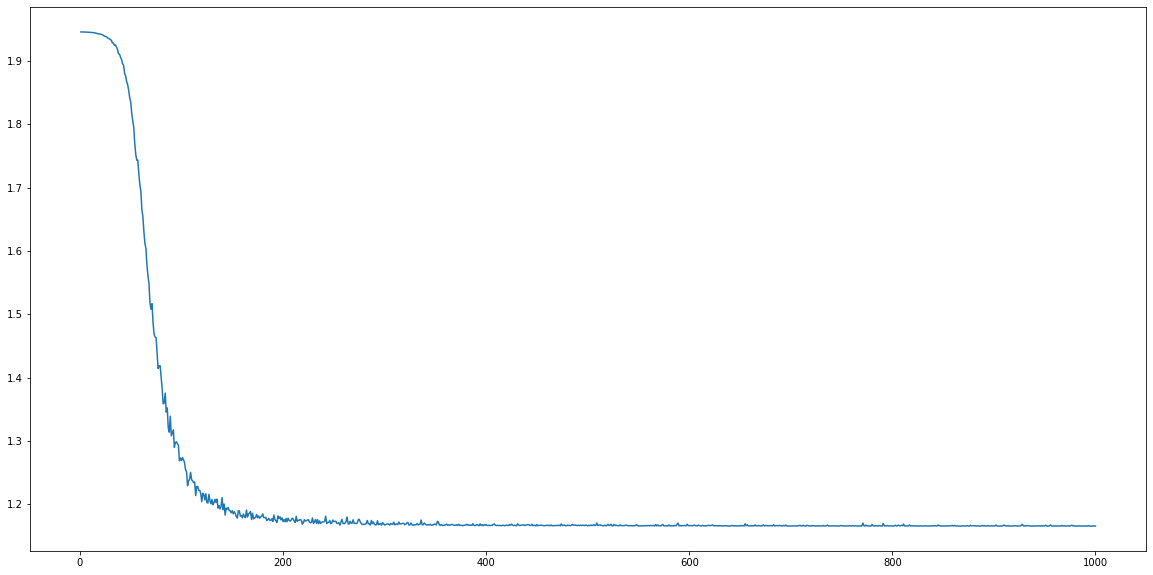

In [220]:
plt.figure(figsize=(20, 10))
plt.plot(history["epoch"], history["loss"])

In [221]:
model.eval()
out = model(dataset.x, dataset.edge_index)
pred = out.argmax(dim = 1)
test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
accuracy = test_correct.sum() / dataset.test_mask.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.746999979019165
